# Correlation between Sensor

In [33]:
import pickle
import re
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from mne_connectivity import envelope_correlation


In [ ]:
# channel names
epo_path = f'data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif'
epochs = mne.read_epochs(epo_path)
epochs.pick_types(eeg=True)
ch_names = epochs.ch_names

# connectivity labels
conn_labels = pd.DataFrame(columns=ch_names, index=ch_names)
conn_labels = conn_labels.apply(lambda x: x.index + ' \N{left right arrow} ' + x.name)
conn_labels = conn_labels.values[np.triu_indices(conn_labels.shape[0], k=0)]

In [ ]:
# Add subject 51 and 52 to the correlation dataset

subjects = ['51', '52']
tasks = ['baseline1',
  'induction1', 'experience1',
  'induction2', 'experience2',
  'induction3', 'experience3',
  'induction4', 'experience4',
  'baseline2',
  ]

conn_df = pd.DataFrame()

for n_sub in subjects:
  for task in tasks: 
    epo_path = f'data/clean_data/sub-{n_sub}_ses-01_task-{task}_proc-clean_epo.fif'
    
    # check if the file exists
    if Path(epo_path).exists():
        epochs = mne.read_epochs(epo_path, preload=True)
        
    else:
        continue
     
    # pick eeg channels
    epochs = epochs.pick_types(eeg=True)
    
    # compute connectivity
    conn = envelope_correlation(epochs, verbose=0)
    conn_ = conn.get_data(output='dense').mean(0)[...,0]
    
    conn_flat = conn_[np.triu_indices(conn_.shape[-1], k=0)]
    conn_df_ = pd.DataFrame(conn_flat, index=conn_labels, columns=[f'{n_sub}_{task}']).transpose()
    conn_df = pd.concat([conn_df, conn_df_], axis=0)
    
# set index
index = []
[index.append(sub + '_' + cond) for sub in subjects for cond in tasks ]
[index.remove(i) for i in ['52_experience2', '52_experience3', '52_induction2', '52_induction3']]
conn_df = conn_df.set_axis(index)

In [68]:
# open behavioral data and ids map
bh = pd.read_csv('docs/plb_hyp_data.csv', index_col='index')
ids_map = pd.read_excel('docs/ids_map.xlsx', header=1, index_col='behavioral_id')
ids_map = ids_map.drop_duplicates('bids_id')
ids_map = ids_map[['bids_id']]
ids_map['bids_id'] = ids_map['bids_id'].apply(lambda x:str(x).zfill(2))
bh = bh.join(ids_map, how='right')
bh = bh.melt(
    id_vars=['procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
             'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4'],
    value_vars=['hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4'])
bh['session'] = bh['variable'].apply(lambda x:x.split('_')[2])
bh['procedure'] = bh.apply(lambda r: r['procedure_type_'+r['session']], axis=1)
bh['description'] = bh.apply(lambda r: r['description_type_'+r['session']], axis=1)
bh = bh[['bids_id', 'value', 'procedure', 'description', 'session']].sort_values(by=['bids_id', 'session']).set_index('bids_id')
bh = bh.rename(columns={'value':'hypnosis_depth'})
bh.reset_index(inplace=True)

conn_df[['bids_id', 'condition']] = conn_df.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
conn_df['session'] = conn_df['condition'].apply(lambda x:x[-1])
conn_df.reset_index(drop=True, inplace=True)
conn_df = pd.merge(bh, conn_df, how='right', on=['session', 'bids_id'], right_index=False)
conn_df = conn_df.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
conn_df.insert(1, 'condition', conn_df.pop('condition'))
conn_df.head()

,bids_id,condition,hypnosis_depth,procedure,description,session,Fp1 ↔ Fp1,Fp1 ↔ Fp2,Fp1 ↔ F3,Fp1 ↔ F4,Fp1 ↔ C3,Fp1 ↔ C4,Fp1 ↔ P3,Fp1 ↔ P4,Fp1 ↔ O1,Fp1 ↔ O2,Fp1 ↔ F7,Fp1 ↔ F8,Fp1 ↔ T7,Fp1 ↔ T8,Fp1 ↔ P7,Fp1 ↔ P8,Fp1 ↔ Fpz,Fp1 ↔ Fz,Fp1 ↔ Cz,Fp1 ↔ CPz,Fp1 ↔ Pz,Fp1 ↔ POz,Fp1 ↔ Oz,Fp1 ↔ Iz,Fp1 ↔ M1,Fp1 ↔ M2,Fp1 ↔ AF3,Fp1 ↔ AF4,Fp1 ↔ F1,Fp1 ↔ F2,Fp1 ↔ F5,Fp1 ↔ F6,Fp1 ↔ FC1,Fp1 ↔ FC2,...,TP7 ↔ P6,TP7 ↔ PO3,TP7 ↔ PO4,TP7 ↔ FCz,TP8 ↔ TP8,TP8 ↔ P1,TP8 ↔ P2,TP8 ↔ P5,TP8 ↔ P6,TP8 ↔ PO3,TP8 ↔ PO4,TP8 ↔ FCz,P1 ↔ P1,P1 ↔ P2,P1 ↔ P5,P1 ↔ P6,P1 ↔ PO3,P1 ↔ PO4,P1 ↔ FCz,P2 ↔ P2,P2 ↔ P5,P2 ↔ P6,P2 ↔ PO3,P2 ↔ PO4,P2 ↔ FCz,P5 ↔ P5,P5 ↔ P6,P5 ↔ PO3,P5 ↔ PO4,P5 ↔ FCz,P6 ↔ P6,P6 ↔ PO3,P6 ↔ PO4,P6 ↔ FCz,PO3 ↔ PO3,PO3 ↔ PO4,PO3 ↔ FCz,PO4 ↔ PO4,PO4 ↔ FCz,FCz ↔ FCz
0,51,baseline1,4.0,embedded,control,1,0.0,0.108517,0.111937,0.107846,0.121839,0.111365,0.119488,0.121581,0.120301,0.125755,0.111474,0.104378,0.116336,0.115525,0.121865,0.133672,0.092573,0.108790,0.110277,0.124519,0.116122,0.120453,0.121585,0.119314,0.096523,0.117843,0.106434,0.106485,0.118249,0.107671,0.106597,0.101148,0.116127,0.110261,...,0.128529,0.130151,0.124726,0.131004,0.0,0.127675,0.124674,0.130819,0.135834,0.142270,0.146345,0.122240,0.0,0.140648,0.141473,0.146290,0.134857,0.140857,0.137201,0.0,0.135659,0.147622,0.136972,0.145045,0.136796,0.0,0.143551,0.147249,0.142617,0.130251,0.0,0.160027,0.160526,0.131565,0.0,0.162861,0.137609,0.0,0.139936,0.0
1,51,experience1,4.0,embedded,control,1,0.0,0.109699,0.118795,0.107292,0.106774,0.116112,0.116924,0.113212,0.124435,0.119009,0.113369,0.105425,0.096013,0.110798,0.110365,0.118042,0.104506,0.114001,0.106319,0.113420,0.106017,0.109194,0.119584,0.117039,0.103147,0.111686,0.113479,0.104960,0.115563,0.107850,0.112330,0.102990,0.110898,0.104711,...,0.119342,0.122108,0.128153,0.119361,0.0,0.130259,0.138569,0.114689,0.141000,0.137651,0.146190,0.126304,0.0,0.122689,0.126865,0.127083,0.129097,0.140142,0.129776,0.0,0.132391,0.137199,0.133873,0.138311,0.132276,0.0,0.131461,0.129930,0.140743,0.117958,0.0,0.139686,0.154339,0.131595,0.0,0.154085,0.129636,0.0,0.137075,0.0
2,51,induction1,4.0,embedded,control,1,0.0,0.111655,0.114764,0.106255,0.116875,0.117629,0.116910,0.123144,0.135292,0.133303,0.122951,0.118428,0.105995,0.107169,0.110339,0.127387,0.108298,0.119883,0.123980,0.121169,0.127054,0.131638,0.135395,0.128096,0.091853,0.120619,0.115566,0.114467,0.116705,0.119605,0.109233,0.106818,0.118666,0.115589,...,0.129457,0.139465,0.137885,0.122977,0.0,0.132787,0.132817,0.134029,0.135764,0.138885,0.142575,0.122350,0.0,0.134050,0.139185,0.152918,0.147170,0.156023,0.124023,0.0,0.138448,0.152485,0.148413,0.141475,0.126395,0.0,0.137167,0.148007,0.140838,0.125241,0.0,0.148795,0.169389,0.132280,0.0,0.158184,0.125083,0.0,0.134978,0.0
3,51,baseline2,2.0,confusion,control,2,0.0,0.107167,0.113740,0.114018,0.113108,0.118650,0.119089,0.121606,0.129065,0.137491,0.097306,0.104078,0.091292,0.102670,0.126079,0.132697,0.104040,0.121036,0.117236,0.119985,0.120907,0.125565,0.129246,0.122734,0.110281,0.119750,0.107697,0.113350,0.118204,0.120786,0.108938,0.104288,0.122440,0.120724,...,0.119743,0.122597,0.124639,0.110785,0.0,0.112642,0.116955,0.110780,0.129467,0.124494,0.141543,0.123234,0.0,0.134763,0.144472,0.136617,0.146757,0.143900,0.139968,0.0,0.135419,0.142130,0.149355,0.164229,0.137605,0.0,0.130788,0.140757,0.143588,0.123092,0.0,0.148448,0.153531,0.124089,0.0,0.165894,0.129902,0.0,0.138477,0.0
4,51,experience2,2.0,confusion,control,2,0.0,0.099666,0.103541,0.099134,0.103801,0.109921,0.116477,0.106238,0.121036,0.115144,0.103825,0.112262,0.084176,0.104274,0.106303,0.119992,0.093294,0.105341,0.101453,0.113132,0.112137,0.114343,0.109359,0.115868,0.096218,0.104623,0.102634,0.107263,0.107235,0.103119,0.096722,0.110852,0.104833,0.106084,...,0.096231,0.114230,0.102729,0.085567,0.0,0.125921,0.120903,0.106478,0.118961,0.125702,0.140071,0.108046,0.0,0.127849,0.116091,0.133594,0.142859,0.140444,0.131563,0.0,0.117671,0.141419,0.137593,0.139760,0.117912,0.0,0.115685,0.125058,0.128992,0.104815,0.

In [53]:
# combine two datasets
corr = pd.read_csv('data/classification_datasets/correlation_sensor.csv', index_col=0)

# change correlation columns names
new_cols = corr.columns[:6].to_list()
new_cols.extend(conn_labels)
corr.columns = new_cols

# concate two datasets and save
corr = pd.concat([corr, conn_df], axis=0)
corr.to_csv('data/classification_datasets/correlation_sensor.csv', index=False)

## Correlation between sensors across classical frequency bands

In [58]:
frequencies = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'lowgamma': (30, 42)  
}

# Envelope Correlation
def get_connectivity(epochs,
                     frequencies: dict,
                     sfreq: float = 1000,
):
    def bp_gen(epochs, fmin, fmax, sfreq):
        for ts in epochs:
            yield mne.filter.filter_data(ts, sfreq=sfreq, l_freq=fmin, h_freq=fmax)
    
    # each segment in epochs is 1 second
    # To compute the connectivity, we want segments that its lenght is about 30 seconds (or a bit less)
    raw = np.hstack(epochs.get_data())
    epochs = np.array_split(raw, 10, axis=1)
    
    conns = {} 
    for bp in frequencies.keys():
        conn_obj = envelope_correlation(bp_gen(epochs, frequencies[bp][0], frequencies[bp][1], sfreq),
                                               orthogonalize='pairwise')
        conn = conn_obj.combine()
        conn = conn.get_data(output='dense')[..., 0]
        conns[bp] = conn
        
    return conns

In [59]:
# open epochs
epochs = mne.read_epochs(paths, preload=True)

# set montage
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)
    
# surface laplacian
# epochs_csd = mne.preprocessing.compute_current_source_density(epochs)

# compute connectivity
conn_without_laplacian = get_connectivity(epochs, frequencies)

Reading /Users/yeganeh/Codes/otka_classification/data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)

Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

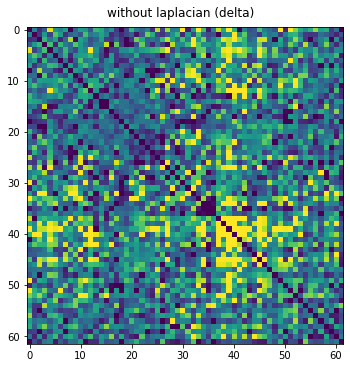

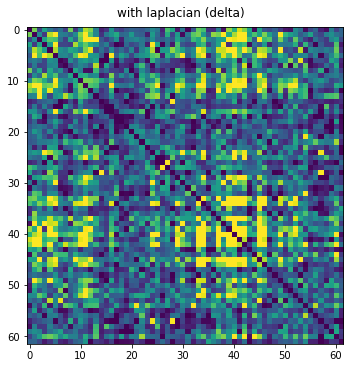

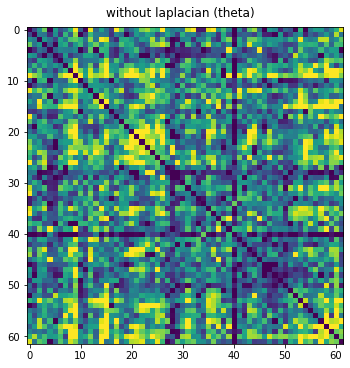

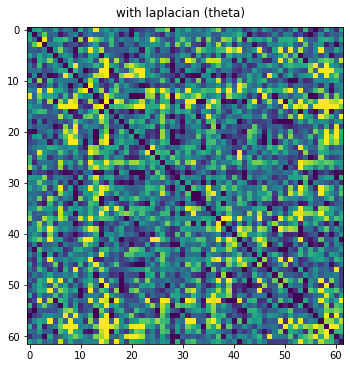

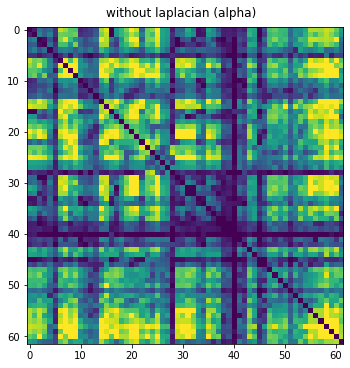

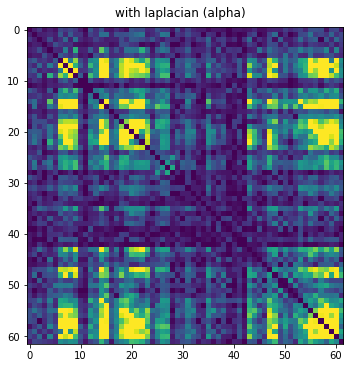

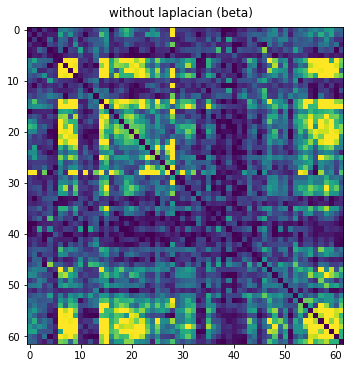

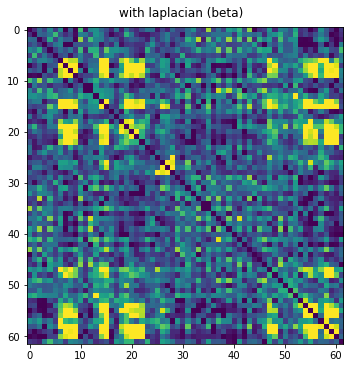

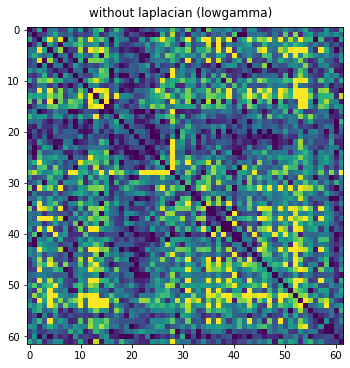

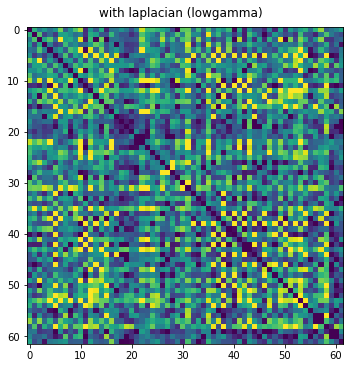

In [66]:
for key in frequencies.keys():
    def plot_corr(corr, title):
        fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
        ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
        fig.suptitle(title)
    plot_corr(conn_without_laplacian[key], f'without laplacian ({key})')
    plot_corr(conn[key], f'with laplacian ({key})')

In [19]:
for subject_path in sorted(Path('data/clean_data').glob('*.fif')):
    subject, task = re.search('(.*)_ses-01_task-(.*)_proc-clean_epo', subject_path.name).groups()

    # open epochs
    epochs = mne.read_epochs(subject_path, preload=True)
    
    # set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    epochs.set_montage(montage)
      
    # surface laplacian
    epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
    
    # compute connectivity
    conn = get_connectivity(epochs_csd, frequencies)

    # save connectivity
    with open(f'data/connectivities/correlation_sensor/{subject}_task-{task}_conn-corr_sensor_filtered.pkl', 'wb') as f:
        pickle.dump(conn, f)

Reading /Users/yeganeh/Codes/otka_classification/data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Fitted sphere radius:         96.9 mm
Origin head coordinates:      -0.8 13.5 41.2 mm
Origin device coordinates:    -0.8 13.5 41.2 mm
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 sample